# Machine Learning Assignment 2 Stella Siu, Jan Kokowski, Tiantian Zhang

##### Task II - Convolutional Autoencoder

# Simple audio recognition: Recognizing keywords

##### Codes are retained for this ipynb (tutorial removed to save space); code optimization is commentted on and sometimes with explanation paragraphs.

## Setup

Import necessary modules and dependencies.

In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers, losses
from tensorflow.keras import models
from IPython import display
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the mini Speech Commands dataset

To save time with data loading, you will be working with a smaller version of the Speech Commands dataset. The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the [WAV (Waveform) audio file format](https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf) of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [ ]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


[Optional: The following code are for running the notebook locally.]

In [ ]:
"""
import os
import tensorflow as tf

# Get the current working directory of the Jupyter Notebook (I do it locally.)
current_dir = os.getcwd()

# Set the custom directory for downloading and extracting the dataset
data_dir = tf.keras.utils.get_file(
    fname='mini_speech_commands.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip',
    extract=True,
    cache_dir=current_dir  # Set the cache directory to the current directory
)

# Update data_dir to point to the extracted folder
data_dir = os.path.join(current_dir, 'datasets', 'mini_speech_commands_extracted','mini_speech_commands')

print(f"Dataset is downloaded and extracted to: {data_dir}")
"""

'\nimport os\nimport tensorflow as tf\n\n# Get the current working directory of the Jupyter Notebook (I do it locally.)\ncurrent_dir = os.getcwd()\n\n# Set the custom directory for downloading and extracting the dataset\ndata_dir = tf.keras.utils.get_file(\n    fname=\'mini_speech_commands.zip\',\n    origin=\'http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip\',\n    extract=True,\n    cache_dir=current_dir  # Set the cache directory to the current directory\n)\n\n# Update data_dir to point to the extracted folder\ndata_dir = os.path.join(current_dir, \'datasets\', \'mini_speech_commands_extracted\',\'mini_speech_commands\')\n\nprint(f"Dataset is downloaded and extracted to: {data_dir}")\n'

In [ ]:
# Check where the dataset is
print(f"Checking directory contents at: {data_dir}")

Checking directory contents at: data/mini_speech_commands


The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['yes' 'go' 'stop' 'up' 'right' 'left' 'down' 'no']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`.

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [ ]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction.

In [ ]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [ ]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [ ]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

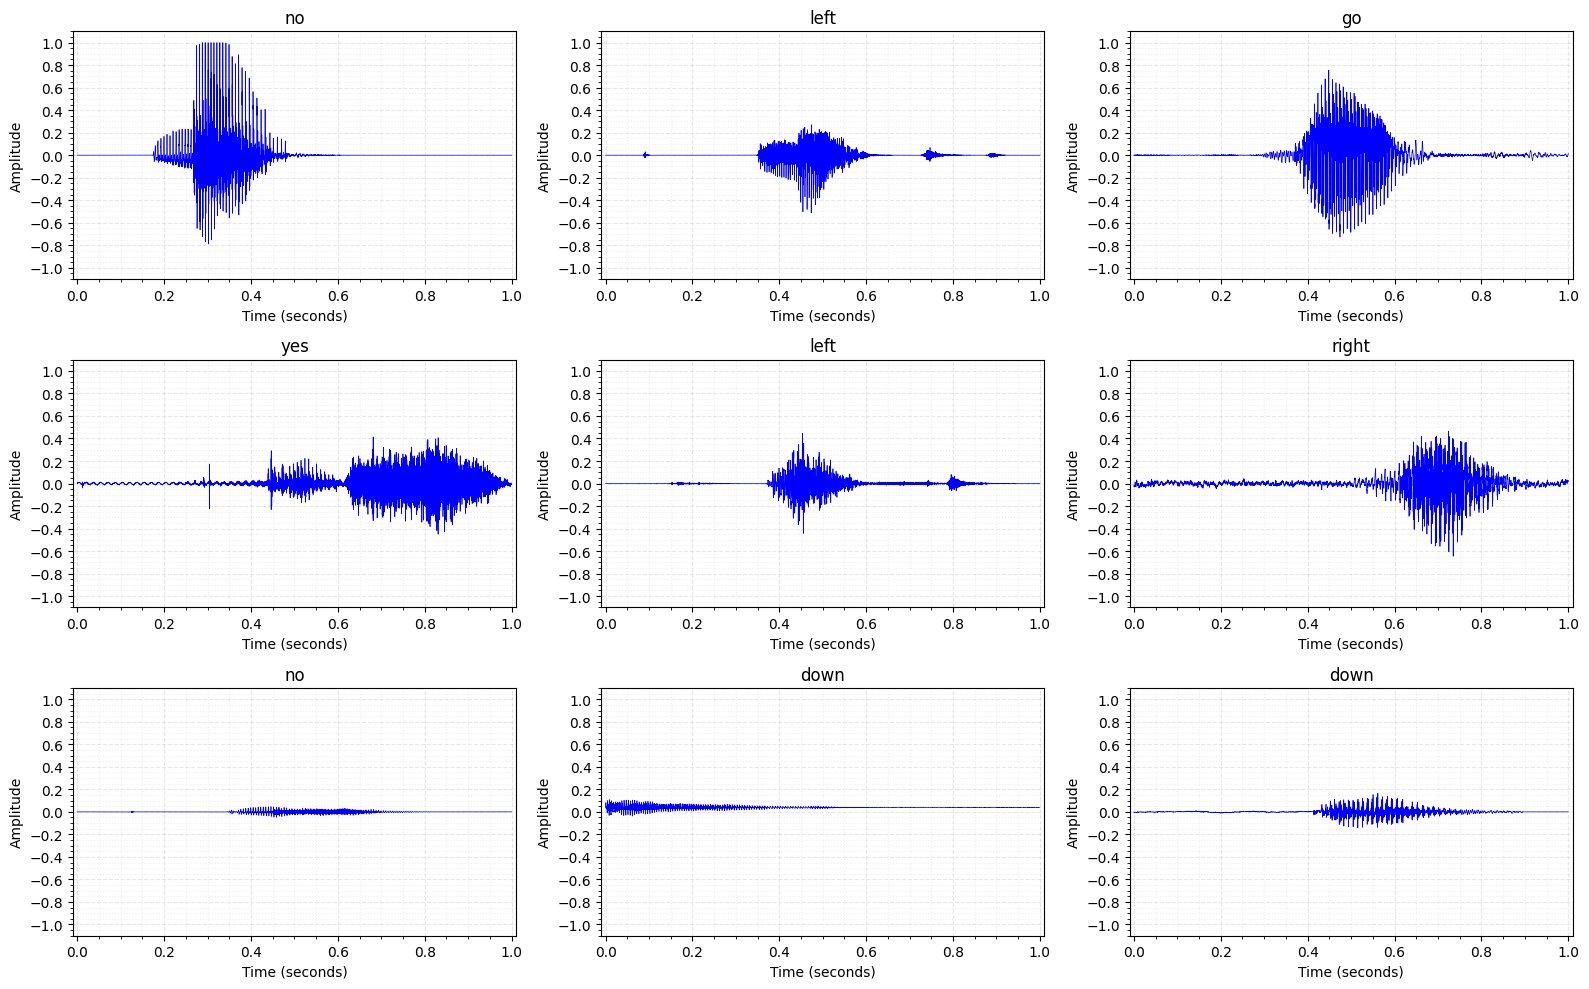

In [ ]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols

for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i+1].numpy()  # Changed i to i+1 to skip the first sample in the batch which could have weaker or less defined waveforms

    # Calculate time axis in seconds (assuming 16kHz sample rate)
    sample_rate = 16000
    time = np.arange(len(audio_signal)) / sample_rate

    plt.plot(time, audio_signal, linewidth=0.5, color='blue', alpha=1.0)
    plt.title(label_names[example_labels[i+1]])  # Changed i to i+1

    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim(-1.1, 1.1)
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', alpha=0.2)
    plt.margins(x=0.01)

plt.tight_layout()
plt.show()

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [ ]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=256, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [ ]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

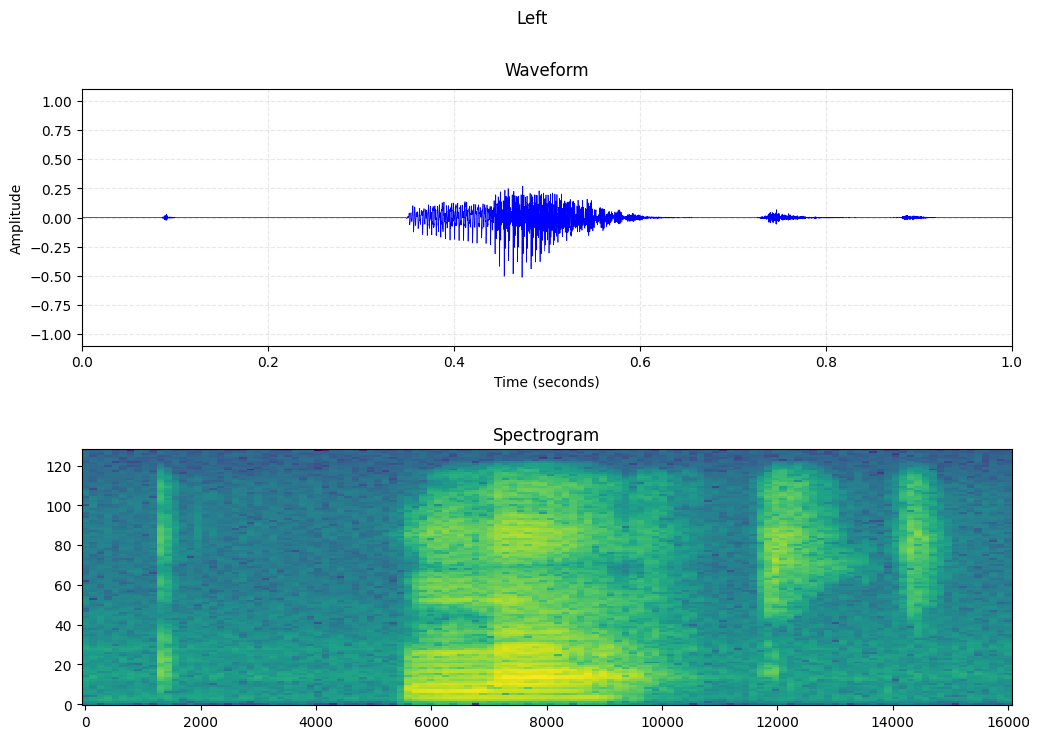

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))

plt.subplots_adjust(hspace=0.4)

sample_rate = 16000
time = np.arange(waveform.shape[0]) / sample_rate

axes[0].plot(time, waveform.numpy(),
             color='blue',
             alpha=1.0,
             linewidth=0.5)

axes[0].set_title('Waveform', fontsize=12, pad=10)
axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, linestyle='--', alpha=0.3)
axes[0].set_xlim([0, len(waveform)/sample_rate])
axes[0].set_ylim([-1.1, 1.1])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [ ]:
# for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
#   break
for element in train_spectrogram_ds.take(1):
    batch_spectrograms, batch_labels = element
    print(batch_labels)
    break

tf.Tensor(
[3 6 7 6 1 2 4 6 5 3 7 5 5 4 5 1 0 5 2 3 0 4 7 6 3 3 7 5 2 3 3 6 5 6 3 0 0
 0 0 1 6 2 7 3 1 2 5 4 2 0 5 4 1 5 6 4 5 1 2 7 5 6 6 2], shape=(64,), dtype=int32)


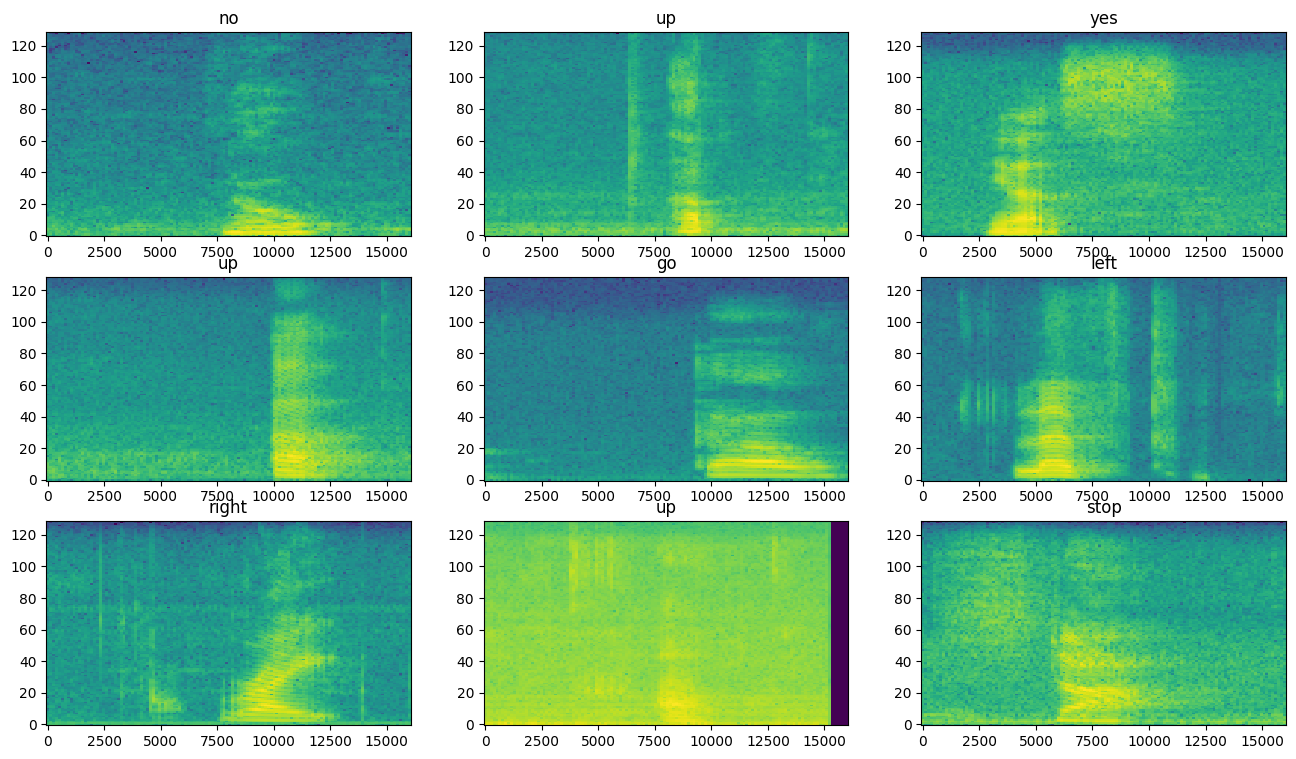

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]

    spectrogram = batch_spectrograms[i].numpy()
    label = batch_labels[i].numpy()

    # Plot the spectrogram
    plot_spectrogram(spectrogram, ax)
    ax.set_title(label_names[label])  # Use label to retrieve the class name

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [ ]:
train_spectrogram_ds_class = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds_class = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds_class = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
# Optimize dataset performance with caching and prefetching
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

# Configure datasets for autoencoder (input = output)
train_spectrogram_ds = train_spectrogram_ds.map(lambda x, y: (x, x))
val_spectrogram_ds = val_spectrogram_ds.map(lambda x, y: (x, x))

# Reshape spectrograms to match model input requirements (batch_size, height, width, channels)
train_spectrogram_ds = train_spectrogram_ds.map(
    lambda x, y: (tf.reshape(x, (64, 124, 129, 1)), tf.reshape(y, (64, 124, 129, 1)))
)
val_spectrogram_ds = val_spectrogram_ds.map(
    lambda x, y: (tf.reshape(x, (64, 124, 129, 1)), tf.reshape(y, (64, 124, 129, 1)))
)

# Verify dataset shapes
for x, y in train_spectrogram_ds.take(1):
    print("Input shape:", x.shape)
    print("Target shape:", y.shape)



Input shape: (64, 124, 129, 1)
Target shape: (64, 124, 129, 1)


The following convolutional autoencoder model compresses spectrograms into a latent space through 3 encoding blocks and reconstructs them through 3 matching decoding blocks. It implements batch normalization and pooling operations.

Model: "Convolutional_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 124, 129, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 124, 129, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 124, 129, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 124, 129, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 62, 65, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 62, 65, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 62, 65, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 62, 65, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 33, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 31, 33, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 31, 33, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 31, 33, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Flatten)               │ (None, 34816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 17, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 17, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 34, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 334,593 (1.28 MB)

 Trainable params: 333,697 (1.27 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.0215 - loss: 0.4816 - val_accuracy: 0.0191 - val_loss: 0.4781
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.0207 - loss: 0.4635 - val_accuracy: 0.0191 - val_loss: 0.4702
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.0214 - loss: 0.4657 - val_accuracy: 0.0191 - val_loss: 0.4656
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.0229 - loss: 0.4540 - val_accuracy: 0.0191 - val_loss: 0.4637
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.0207 - loss: 0.4619 - val_accuracy: 0.0191 - val_loss: 0.4631
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.0205 - loss: 0.4653 - val_accuracy: 0.0191 - val_loss: 0.4632
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.0209 - loss: 0.4553 - val_accuracy: 0.0191 - val_loss: 0.4627
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.0202 - loss: 0.4547 - val_a

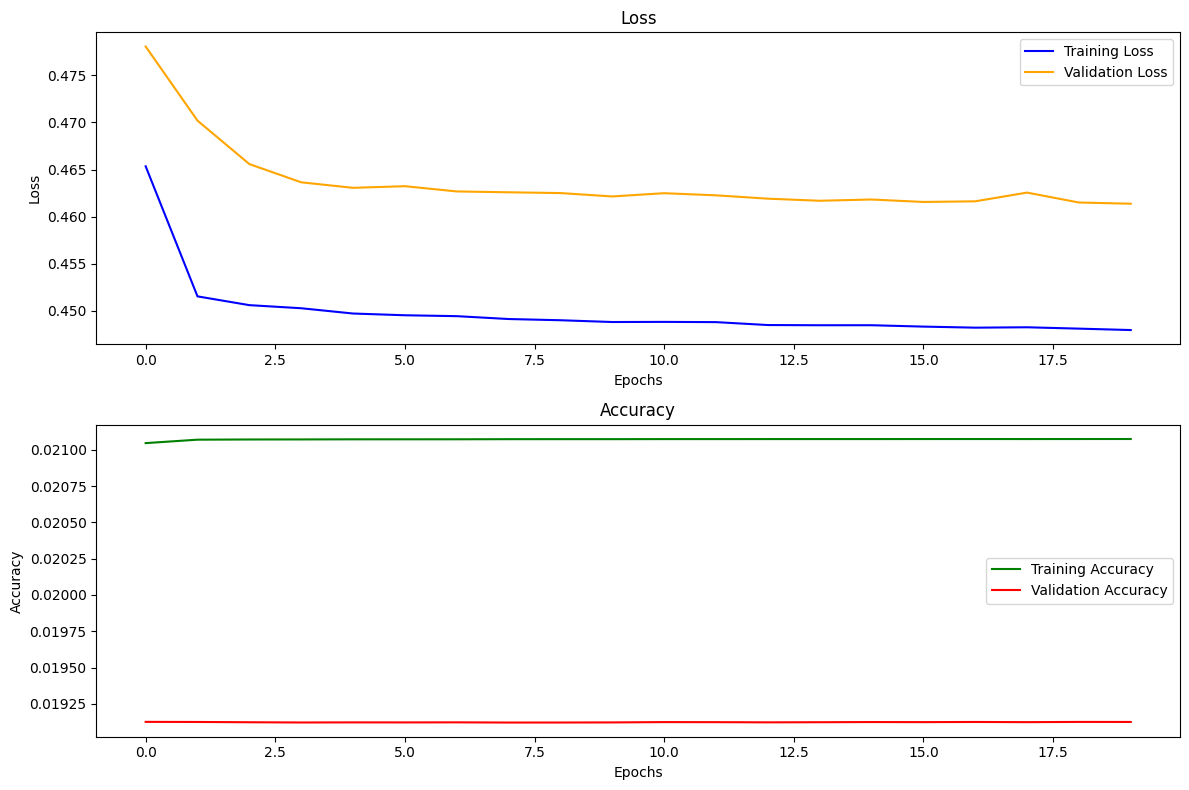

In [ ]:
# Define input shape for spectrogram (height, width, channels)
input_shape = (124, 129, 1)

# Encoder
encoder_input = layers.Input(shape=input_shape, name="encoder_input")

# Encoder block 1: 32 filters
x = layers.Conv2D(32, (3, 3), padding='same')(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

# Encoder block 2: 64 filters
x = layers.Conv2D(64, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

# Encoder block 3: 128 filters
x = layers.Conv2D(128, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

# Flatten to latent space
latent_space = layers.Flatten(name="latent_space")(x)

# Decoder: reshape to match encoder output
x = layers.Reshape((16, 17, 128))(latent_space)

# Decoder block 1: 128 filters
x = layers.Conv2DTranspose(128, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.UpSampling2D((2, 2))(x)

# Decoder block 2: 64 filters
x = layers.Conv2DTranspose(64, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.UpSampling2D((2, 2))(x)

# Decoder block 3: 32 filters
x = layers.Conv2DTranspose(32, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.UpSampling2D((2, 2))(x)

# Crop to match input dimensions
x = layers.Cropping2D(cropping=((4, 0), (7, 0)))(x)

# Final reconstruction layer
decoded_output = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same', name="decoder_output")(x)

# Create and compile model
autoencoder = models.Model(encoder_input, decoded_output, name="Convolutional_Autoencoder")
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
autoencoder.summary()

# Train model
history_autoencoder = autoencoder.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=20
)

# Visualize training results
metrics = history_autoencoder.history
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(metrics['loss'], label='Training Loss', color='blue')
plt.plot(metrics['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(metrics['accuracy'], label='Training Accuracy', color='green')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

 Restructure and optimize the spectrogram datasets for classification by setting proper input dimensions and batch sizes:

In [ ]:
# Reshape spectrograms for classification:
# x: (-1, 124, 129, 1) -> (batch, height, width, channels)
# y: (-1,) -> (batch,) for class labels
train_spectrogram_ds_class = train_spectrogram_ds_class.map(
    lambda x, y: (tf.reshape(x, (-1, 124, 129, 1)), tf.reshape(y, (-1,)))
)
val_spectrogram_ds_class = val_spectrogram_ds_class.map(
    lambda x, y: (tf.reshape(x, (-1, 124, 129, 1)), tf.reshape(y, (-1,)))
)

# Optimize dataset pipeline:
# 1. unbatch() to remove any existing batching
# 2. batch(32) to create new batches of size 32
# 3. prefetch() for parallel data loading
train_spectrogram_ds_class = train_spectrogram_ds_class.unbatch().batch(32).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds_class = val_spectrogram_ds_class.unbatch().batch(32).prefetch(tf.data.AUTOTUNE)

# Verify the shapes of input spectrograms and labels
for x, y in train_spectrogram_ds_class.take(1):
    print("Input shape:", x.shape)   # Should be (32, 124, 129, 1)
    print("Label shape:", y.shape)   # Should be (32,)



Input shape: (32, 124, 129, 1)
Label shape: (32,)


Construct the classification model by combining our pre-trained encoder with a new classification layer:

In [ ]:
# Extract the encoder from the autoencoder
encoder = models.Model(autoencoder.input, autoencoder.get_layer("latent_space").output, name="Encoder")
encoder.summary()  # Verify the encoder architecture

# Add a Dense layer for classification
latent_input = layers.Input(shape=encoder.output.shape[1:], name="latent_input")
classifier_output = layers.Dense(8, activation='softmax', name="classifier_output")(latent_input)

# Create the classifier model
classifier = models.Model(latent_input, classifier_output, name="Dense_Classifier")
classifier.summary()

# Combine the encoder and the classifier
encoder.trainable = True  # Allow fine-tuning of the encoder
full_model = models.Model(encoder.input, classifier(encoder.output), name="Full_Model")

# Compile the full model
full_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
full_model.summary()

# train_spectrogram_ds_class = train_spectrogram_ds.map(lambda x, y: (x, y))
# train_spectrogram_ds_class = train_spectrogram_ds_class.batch(32).prefetch(tf.data.AUTOTUNE)

# val_spectrogram_ds_class = val_spectrogram_ds.map(lambda x, y: (x, y))
# val_spectrogram_ds_class = val_spectrogram_ds_class.batch(32).prefetch(tf.data.AUTOTUNE)

# Train the full model
history = full_model.fit(
    train_spectrogram_ds_class,  # Training dataset
    validation_data=val_spectrogram_ds_class,  # Validation dataset
    epochs=50
)



Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 124, 129, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 124, 129, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 124, 129, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 124, 129, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 62, 65, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 62, 65, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 62, 65, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 62, 65, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 33, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 31, 33, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 31, 33, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 31, 33, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Flatten)               │ (None, 34816)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,568 (365.50 KB)

 Trainable params: 93,120 (363.75 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "Dense_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ latent_input (InputLayer)            │ (None, 34816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classifier_output (Dense)            │ (None, 8)                   │         278,536 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 278,536 (1.06 MB)

 Trainable params: 278,536 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

Model: "Full_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 124, 129, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 124, 129, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 124, 129, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 124, 129, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 62, 65, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 62, 65, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 62, 65, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 62, 65, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 33, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 31, 33, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 31, 33, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 31, 33, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Flatten)               │ (None, 34816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_Classifier (Functional)        │ (None, 8)                   │         278,536 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 372,104 (1.42 MB)

 Trainable params: 371,656 (1.42 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
    200/Unknown 10s 20ms/step - accuracy: 0.3051 - loss: 3.6041

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.3056 - loss: 3.5979 - val_accuracy: 0.4466 - val_loss: 2.0151
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6470 - loss: 1.1129 - val_accuracy: 0.6562 - val_loss: 1.0112
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7917 - loss: 0.6580 - val_accuracy: 0.6367 - val_loss: 1.2576
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8396 - loss: 0.5209 - val_accuracy: 0.8164 - val_loss: 0.6471
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8883 - loss: 0.3395 - val_accuracy: 0.8255 - val_loss: 0.5836
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9277 - loss: 0.2324 - val_accuracy: 0.8516 - val_loss: 0.5652
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9274 - loss: 0.2275 - val_accuracy: 0.8307 - val_loss: 0.6086
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9340 - loss: 0.2024 - val_accuracy: 0.83


Final Training Metrics:
Loss: 0.0231
Accuracy: 0.9934

Final Validation Metrics:
Loss: 0.9038
Accuracy: 0.8659


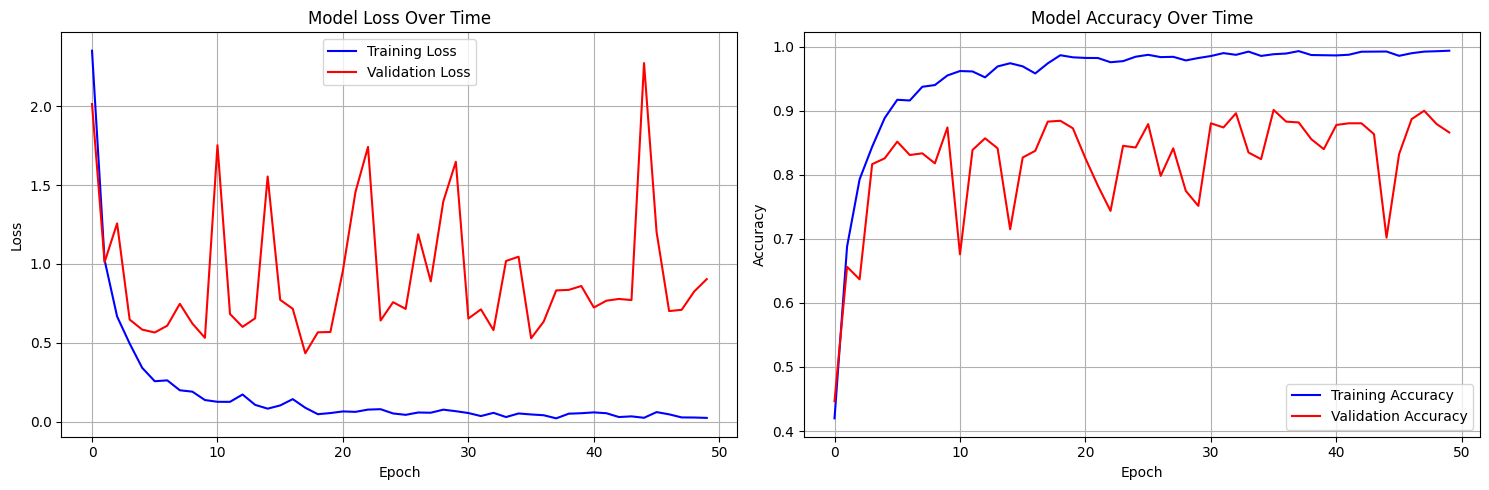

In [ ]:
# Print final metrics
print("\nFinal Training Metrics:")
print(f"Loss: {history.history['loss'][-1]:.4f}")
print(f"Accuracy: {history.history['accuracy'][-1]:.4f}")
print("\nFinal Validation Metrics:")
print(f"Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Accuracy: {history.history['val_accuracy'][-1]:.4f}")

# Visualize training metrics
plt.figure(figsize=(15, 5))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Model Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Final Configuration and Experimentation

We achieved notable performance after 50 epochs with the original input size (124, 129) and a deep CNN architecture with batch normalization. The model showed strong learning capability but exhibited signs of overfitting in later epochs.


### Key observations from the final configuration:

1. Very high training accuracy (99.50%) indicates strong model capacity
2. Gap between training and validation metrics suggests overfitting. However, given the late convergence, we did not add an early stopping and let the model finish 50 epochs to reach high accuracy
3. Validation accuracy of 87.37% shows good generalization despite overfitting

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [ ]:
# Evaluate the model on test dataset
full_model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8490 - loss: 0.9596


{'accuracy': 0.854567289352417, 'loss': 1.0220673084259033}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [1]:
y_pred = []
y_true = []

for x, y in val_spectrogram_ds_class:
    predictions = full_model.predict(x)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(y.numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)  # Add label names
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

NameError: name 'val_spectrogram_ds_class' is not defined

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

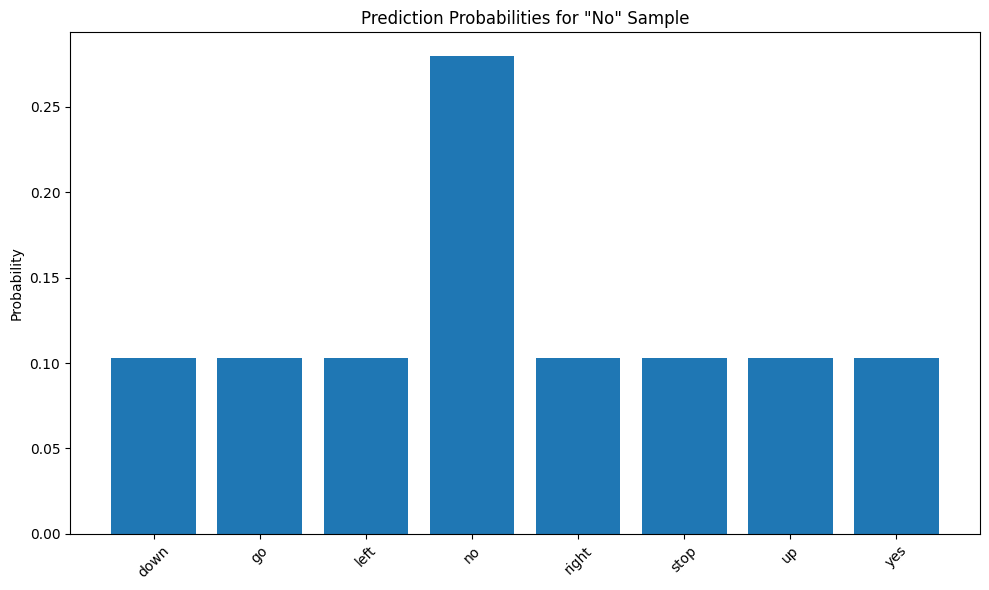

In [ ]:
x_path = os.path.join(data_dir, 'no', '01bb6a2a_nohash_0.wav')

x = tf.io.read_file(str(x_path))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = full_model(x)

# Get the base labels and add the additional classes
base_labels = label_names.tolist()
complete_labels = base_labels #+ ['silence', 'unknown']  # Add the missing classes

plt.figure(figsize=(10, 6))
probabilities = tf.nn.softmax(prediction[0]).numpy()
plt.bar(complete_labels, probabilities)
plt.title('Prediction Probabilities for "No" Sample')
plt.xticks(rotation=45)
plt.ylabel('Probability')
plt.tight_layout()
plt.show()

display.display(display.Audio(waveform, rate=16000))

As the output suggests, your autoencoder-based model has recognized the audio command as "no" though not as confidently as the CNN model.